# Parallel Tempering

In the following code, we will use data from https://www.nature.com/articles/s41586-021-03778-8

In this case, we will align the last four connectome networks, corresponding to the latest stages of development: L2,L3, A1, A2

In this notebook we are not working with weighted networks, only with the presence or not of a connection (Binary adjacency matrices).

In that database we have information about the neuron type (the neuroblast it belongs to). 
In this notebook we choose some nodes (~10%) to have unknwon group labels, and we want to see if we are still able to recover the mapping and also infer their group label (we see in which group the neuron spend the majority of its time). 
Always there is a networks with all the neurons labeled (to have a reference). The rest, these unknowns neurons are chosen randomly, but proportionated to the size of the group. They can be chosen DIFFERENT in all the networks, or the SAME. 

In [22]:
import itertools
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import time
from numba import jit, njit
from numba.types import bool_, int_, float32
from math import comb
from copy import deepcopy
from tqdm import tqdm
import networkx as nx
import pandas as pd
from collections import defaultdict
from itertools import permutations

# DATASET

In [23]:
### Open the files
tablas = 8
n_grupo = 4

d = {}
D = "Dataset"
for i in range(0,tablas):
    d["group" + str(i)] = pd.read_excel("datasets.ods", sheet_name=D+str(i+1))
    print('Read:',i, 'size', d["group" + str(i)].shape)

Read: 0 size (227, 183)
Read: 1 size (227, 183)
Read: 2 size (227, 183)
Read: 3 size (227, 183)
Read: 4 size (227, 183)
Read: 5 size (227, 183)
Read: 6 size (227, 183)
Read: 7 size (227, 183)


In [24]:
## Hipermatrix M with the data (Only the synapses) 
rows = d["group" + str(i)].shape[0] - 3
columns = d["group" + str(i)].shape[1] - 3

M = np.zeros((tablas,rows,columns))
for i in range(0, tablas):
    Data = d['group' + str(i)]
    M[i,:,:] = Data.iloc[3:,3:]
    
## Since we work with same number of nodes, we want them equal and square (zeros when no connections)
M_square = np.zeros((tablas, rows, rows))
M_square[:,:, 0:columns] = M[:,:,:]

## Binarization: No weights
#Lo queremos BINARIO, ignorando su peso (Luego pensar cómo se haría con el peso)
M_square_bin = np.zeros((tablas,rows,rows))
for i in range(tablas):
    for j in range(rows):
        for k in range(columns):
            if (M[i,j,k] >= 1):
                M_square_bin[i,j,k] = 1
                
Nx = rows # Number of nodes (we imposed rows == columns)

### GROUP INFORMATION

In [25]:
# Groups from the database
Sensory = 69-5 #0
Inter = 113-70 # 1
Motor = 155-114 #2
Modulatory = 184-156 #3
Muscle = 216-185 #4 
Others = 228-217 #5

size_groups = np.array([Sensory, Inter, Motor, Modulatory, Muscle, Others]) + 1 #Started in 0
n_groups = len(size_groups)
start_groups = np.zeros(n_groups)
end_groups = np.zeros(n_groups)


print('grupos: Sensory, Inter, Motor, Modulatory, Muscle, Other')
print('SIZE GROUPS:', size_groups)


#Para evitar trabajar con diccionarios (por NUMBA), vamos a hacer matrices 
# Cada matriz tiene el tamaño de la de mayor, pero luego las vamos cortando
rows_g, columns_g = size_groups.max(), size_groups.max()

size_suma = 0
start_groups[0] = 0
for i in range(n_groups):
    size = size_groups[i]
    if (i != n_groups-1):
        start_groups[i+1] = int(size_suma + size)
    size_suma = size_suma + (size) 
#end
for i in range(0,n_groups):
    if (i!= n_groups-1):
        end_groups[i] = start_groups[i+1]
    else:
        end_groups[i] = Nx
start_groups = start_groups.astype(int)
end_groups = end_groups.astype(int)

print('***********************************')
print('First node in each group', start_groups)
print('Last node in each group', end_groups)



grupos: Sensory, Inter, Motor, Modulatory, Muscle, Other
SIZE GROUPS: [65 44 42 29 32 12]
***********************************
First node in each group [  0  65 109 151 180 212]
Last node in each group [ 65 109 151 180 212 224]


## ENERGY FUNCTIONS


In [26]:
@jit(nopython = True)
def hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta):

    A_1 = overlap_1 + alpha
    B_1 = (Edges_L - overlap_1 + beta)
    C_1 = Edges_L + alpha + beta
    
    A_0 = overlap_0 + alpha
    B_0 = (Edges_NoL - overlap_0 + beta)
    C_0 = Edges_NoL + alpha + beta
    
    #  [ math.lgamma(n+1) == log(n!) ]
    H1 = math.lgamma(A_1)+ math.lgamma(B_1) - math.lgamma(C_1) 
    H0 = math.lgamma(A_0)+ math.lgamma(B_0) - math.lgamma(C_0) 
    
    H = -(H1 + H0)
    return H
    
    
@jit(nopython=True)
def overlap_total_prob(L_f, A_f, P_inv_f):
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    
    ovlp_0 = np.zeros((K))
    ovlp_1 = np.zeros((K))
    for k in range(0,K):
        for f in range(0,Ny): 
            for c in range(0,Nx):
                p_f=int(P_inv_f[k,f])
                p_c=int(P_inv_f[k,c])  
                
                valor_L, valor_A = L_f[f,c], A_f[k,p_f,p_c]
                
                ovlp_0[k] = ovlp_0[k] + (1-valor_L)*(1-valor_A )
                ovlp_1[k] = ovlp_1[k] + valor_L*valor_A
                
                
    ovlp_1 = int(sum(ovlp_1))
    ovlp_0 = int(sum(ovlp_0))
    return ovlp_0, ovlp_1


@jit(nopython=True) # The blueprint is the average of the observations (taking into account the mapping)  
def L_wiring(A_f, P_inv_f):
    
    Nx = A_f.shape[1]
    Ny = A_f.shape[2]
    K = A_f.shape[0]
    L_new_f = np.zeros((Nx,Ny))
    
    for i in range(0,Nx):
        for j in range(0,Ny):
            for k in range(0,K):
        
                p1 = int(P_inv_f[k,i]) # Mapping of the observations
                p2 = int(P_inv_f[k,j]) # Mapping of the observations
                L_new_f[i,j] += A_f[k,p1,p2]
            valor_lnew=1/K* L_new_f[i,j]
            L_new_f[i,j] = round( valor_lnew ) 
            # If valor_lnew = 0, L=0 (we could establish L=1, but it is more probable to not have a connection)
    
    return L_new_f


#### Some algorithm for sorting
@jit(nopython=True)
def partition(array,  etiquetas, begin, end):
    pivot = begin
    for i in range(begin+1, end+1):
        if array[i] < array[begin]:
            pivot += 1
            array[i], array[pivot] = array[pivot], array[i]
            etiquetas[i], etiquetas[pivot] = etiquetas[pivot], etiquetas[i]
    array[pivot], array[begin] = array[begin], array[pivot]
    etiquetas[pivot], etiquetas[begin] = etiquetas[begin], etiquetas[pivot] 

    return pivot
@jit(nopython=True)
def quicksort(array, etiquetas, begin=0, end=None):
    if end is None:
        end = len(array) - 1
    if begin >= end: #To end
        return
    pivot = partition(array,  etiquetas, begin, end)
    
    #Order right and left
    quicksort(array, etiquetas, begin, pivot-1)
    quicksort(array,  etiquetas, pivot+1, end)


# Some nodes are unkwon and are located random in the end of the places
def permu_groups_unk_capa1(L_f, A_f, start_f, unkwn, grupos_t):    
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    N_groups = len(start_f)
    
    # Mappings
    P_f = np.zeros((K,Nx)) #Mapping from L to A
    P_inv_f = np.zeros((K,Nx)) #Mapping from A to L
    P_new = np.zeros((K,Nx))
    
    #Blueprints
    orden_L_in = np.zeros((Nx))
    array_L = np.arange(Nx)

    for i in range(Nx):
        b = np.nonzero(L_f[i,:])
        orden_L_in[i] = b[0].size#.size

    orden_L = orden_L_in.copy()
    quicksort(orden_L, array_L)
    array_L = array_L[::-1]
    
    grupos_L = np.zeros((Nx))
    for  i_g in range(N_groups):
        start = start_f[i_g]
        if (i_g != N_groups-1):
            end = start_f[i_g+1]
        else:
            end = Nx
        grupos_L[start:end] = i_g
    grupos_L = grupos_L.astype(int)
    orden_L = orden_L_in.copy()
    quicksort(orden_L, grupos_L )
    grupos_L = grupos_L[::-1]
        
    
    #Observations
    for m in range(0,K):
        orden_A_in = np.zeros((Nx))
        grupos_A = np.zeros((Nx))
        array_A = np.arange(Nx)

        for i_orden in range(Nx):
            b = np.nonzero(A_f[m,i_orden,:])
            orden_A_in[i_orden] = b[0].size
            grupos_A[i_orden] = grupos_t[m, i_orden]

        orden_A = orden_A_in.copy()
        quicksort(orden_A, array_A)
        array_A = array_A[::-1]

        orden_A = orden_A_in.copy()
        quicksort(orden_A, grupos_A)
        grupos_A = grupos_A[::-1]
        
        array_A_L = np.zeros((Nx))
        nodos = []
        for i_n in range(Nx): 
            if ((grupos_A[i_n] == grupos_L[i_n]) or (grupos_A[i_n] == N_groups)):
                array_A_L[i_n] = array_A[i_n]
                nodos.append(i_n)
            else:
                # Look for the next one with the same group label and i change it 
                count = 0
                for i_nn in range(0, Nx):
                    if i_nn not in nodos:
                        if ((grupos_A[i_nn] == grupos_L[i_n]) or (grupos_A[i_nn] == N_groups)): 

                            aux = array_A[i_nn]
                            array_A_L[i_n] = array_A[i_nn]
                            array_A[i_nn] = array_A[i_n]
                            #array_A[i_n] = aux

                            aux = grupos_A[i_nn]
                            grupos_A[i_nn] = grupos_A[i_n]
                            grupos_A[i_n] = aux
                            nodos.append(i_n)
                            count = 1
                            break
                            
                if (count == 0): #There is no place in its group 
                    #we need to do a change with an unknwon in its group 
                    grupo = grupos_A[i_n]

                    extras_A = np.where( grupos_A == N_groups)[0]
                    extras_L = np.where(grupos_L == grupo)[0]
         
                    inter = np.array(list(set(extras_A).intersection(extras_L)))
                    unkwn_1 = random.choice(inter)
                    # Locate
                    array_A_L[i_n] = array_A_L[unkwn_1]
                    # Change
                    array_A_L[unkwn_1] = array_A[i_n]
                    aux = grupos_A[unkwn_1]
                    grupos_A[unkwn_1] = grupos_A[i_n]
                    grupos_A[i_n] = grupos_A[unkwn_1]
                    nodos.append(i_n)

        array_A_L = array_A_L[np.argsort(array_L)]
        P_f[m,:] = array_A_L
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_f[m,i_inv] == j_inv):
                    P_inv_f[m, j_inv]=i_inv
    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy()
    P_todo[1,:,:] = P_inv_f.copy()

    return P_todo


# This function can be generalized for having the labeled-nodes in any of the networks. In this case  in the last one
def def_unkwn_nodes(chosen_unk,K,n_groups,groups_ini, labels_unkwons_ini):
    if chosen_unk == 0: # All unkwons nodes different across networks
        for m1 in range(K):
            count = 0
            # Si no llega al maximo rellenamos el final
            if (num_unk[m1]< max_num):
                extras = int(max_num - num_unk[m1])
                labels_unkwons_ini[m1, - extras: ] = Nx+1
            for i_g in range(n_groups):
                start = start_groups[i_g]
                end = end_groups[i_g]
                groups_ini[m1,start:end] = i_g
                groups_ini_0[m1,start:end] = i_g
                nodos = []
                for i_un in range(num[m1,i_g]):
                    nodo1 = np.random.randint(start,end)
                    while (nodo1 in nodos):
                        nodo1 = np.random.randint(start,end)
                    nodos.append(nodo1)
                    labels_unkwons_ini[m1, count] = nodo1            
                    count +=1
    else:  # All unkwons nodes the same across networks
        count = 0
        for i_g in range(n_groups):
            start = start_groups[i_g]
            end = end_groups[i_g]
            groups_ini[:,start:end] = i_g
            groups_ini_0[:,start:end] = i_g
            nodos = []
            for i_un in range(num[-1,i_g]):# If the all-labeled nodes are in the last one 
                nodo1 = np.random.randint(start,end)
                while ((nodo1 in nodos) ):
                    nodo1 = np.random.randint(start,end)
                groups_ini[1:,nodo1] = group_extra # groups_ini[1:,nodo1] IF it is the first one  
                nodos.append(nodo1)
                labels_unkwons_ini[1:, count] = nodo1 # labels_unkwons_ini[1:,nodo1] IF it is the first one            
                count +=1
    return groups_ini, labels_unkwons_ini, nodos


## INITIAL CONDITIONS

We will align the 4 last networks: L2, L3, A1, A2

In [27]:
Nx = rows # Nodes
K = 4 # Number of networks
alpha,beta = 5,2 # Values for the beta prior distribution 
Edges = Nx*Nx 
micropasos = Edges*K #Microsteps for each MCMC
A = np.zeros((K,Nx,Nx))
A = M_square_bin[4:, :,:] #Only the latest four                
print('OBSERVATIONS')  
print(A.shape)
####################################

## INITIALIZATION ##

L_ini = np.zeros((Nx,Nx))
P_ini_0 = np.zeros((K,Nx))
P_inv_ini_0 = np.zeros((K,Nx))

# We inizialize with the Blueprint = L2
L_ini = (A[0,:,:]).copy()

groups_ini = np.zeros((K,Nx)) #Groups label
for m1 in range(K):
    for i_g in range(n_groups):
        start = start_groups[i_g]
        end = end_groups[i_g]
        groups_ini[m1, start:end] = i_g
        
## Overlaps
ovlp_ini0, ovlp_ini1 = overlap_total_prob(L_ini,A,P_inv_ini_0)


OBSERVATIONS
(4, 224, 224)


## UNKWNON LABEL: 

In this case we choose at the begining if we want same or different unkwon nodes (in the networks with unkwon nodes, K-1)

In [28]:
# chosen = 1 (same), 0(different)
chosen_unk = 1

## Now we have an extra group 
group_extra = (n_groups-1) + 1
# Unkwon nodes prop to the group size
num = np.zeros((K, n_groups))
## Last networks (A2) all labeled: Change this if i want another network
num[1:,:] = np.round(size_groups*0.1)

## In the case in each network we have different quantity of unkwon (Not in this case)
num_unk = np.zeros(K) 
for i in range(K):
    num_unk[i] = sum(num[i,:])
num = num.astype(int)
num_unk = num_unk.astype(int)
# Voy a hacer vectores del máximo. Los que no lleguen al máximo los ponemos con Nx+1 o un número alto (ahora no implementado)
# In the case each network different quantity, we fill with (Nx+1) the spaces
max_num = (np.amax(num_unk))
posi_unkwons_ini = np.zeros ((K,max_num))+ (Nx+1) # Esto son los unkwons que luego voy a mezclar
labels_unkwons_ini = np.zeros ((K,max_num)) + (Nx+1)
groups_ini_0 = np.zeros((K,Nx))
groups_ini = groups_ini_0.copy()

groups_ini, labels_unkwons_ini, nodos = def_unkwn_nodes(chosen_unk,K,n_groups,groups_ini, labels_unkwons_ini)

# Initial mapping taking into account the unkwon nodes
P_inis = permu_groups_unk_capa1(L_ini, A, start_groups,labels_unkwons_ini,groups_ini) 
P_inis = P_inis.astype(int)
P_ini_0 = (P_inis[0,:,:]).copy()
P_inv_ini_0 = (P_inis[1,:,:]).copy()

#Now the position of these nodes
groups_ini = groups_ini_0.copy()
for m1 in range(K):
    for i_n in range(max_num):
        label = int(labels_unkwons_ini[m1,i_n])
        if (label != Nx+1):
            posi_unkwons_ini[m1,i_n] = P_inv_ini_0[m1,label]
            posi = int(P_inv_ini_0[m1,label])
            groups_ini[m1,posi] = group_extra
        else:
            posi_unkwons_ini[m1,i] = Nx+1
#Integer            
labels_unkwons_ini_0 = labels_unkwons_ini.astype(int)
groups_ini_0 = groups_ini.astype(int)
posi_unkwons_ini_0 = posi_unkwons_ini.astype(int)
labels_unkwons_ini = labels_unkwons_ini.astype(int)
groups_ini = groups_ini.astype(int)
posi_unkwons_ini = posi_unkwons_ini.astype(int)
          
print('Unkwon nodes per network')
print(labels_unkwons_ini_0[:,:])



Unkwon nodes per network
[[225 225 225 225 225 225 225 225 225 225 225 225 225 225 225 225 225 225
  225 225 225]
 [ 17  57  47  32  46  25  84  79 101  97 125 113 112 111 171 158 153 200
  195 204 212]
 [ 17  57  47  32  46  25  84  79 101  97 125 113 112 111 171 158 153 200
  195 204 212]
 [ 17  57  47  32  46  25  84  79 101  97 125 113 112 111 171 158 153 200
  195 204 212]]


In [29]:
# We will propose changes when K-1 nodes are unkwon in the same position. N.B: At least we need two positions!

vector_unkwn_ini = np.zeros((Nx))
for i_x in range(Nx):
    for m1 in range(K):
        if ( groups_ini[m1, i_x] == group_extra):
            vector_unkwn_ini[i_x] += 1

print('# 3 unkwons:',len(np.where(vector_unkwn_ini==(K-1))[0]))
print('Position:', P_ini_0[:,np.where(vector_unkwn_ini==(K-1))])


# 3 unkwons: 1
Position: [[[204]]

 [[158]]

 [[212]]

 [[212]]]


In [30]:
#Store it to sample with the same nodes
d_store={}
string = "Matriz_unkwn_epochs_L2_"+str(chosen_unk)+".pickle"
print(string)
d_store["A"] = A
d_store["labels_unkwons_ini_0"]= labels_unkwons_ini_0
d_store["posi_unkwons_ini_0"] = posi_unkwons_ini_0
d_store["vector_unkwn_ini"] = vector_unkwn_ini
d_store["groups_ini_0"] = groups_ini_0
d_store["P_ini_0"] = P_ini_0
d_store["P_inv_ini_0"] = P_inv_ini_0

file1 = open(string,"wb")
pickle.dump( d_store, file1)
file1 = open(string,"wb")
pickle.dump( d_store, file1)
prueba = pickle.load(open(string, "rb"))

Matriz_unkwn_epochs_L2_1.pickle


## Temperatures

We are permorfing a Parallel tempering Markov Chain MonteCarlo

We run our MCMC at difference temperatures (proposing changes between them), and we will sample at temper = 1

In [31]:
# Temperature distributin
beta_o = 1.03
total = 15 # Odd name, in order to have beta = 1
b_exp = np.linspace(-5,5,num = total)
tempers = beta_o**b_exp # Account for 1/KT, called beta in thermodinamics
print('betas:', tempers)
N_t = len(tempers)

## Inizialitation of the system for each temperature, with the same mappings
P_ini_t = np.zeros((N_t,K,Nx))
P_inv_ini_t = np.zeros((N_t,K,Nx))
L_ini_t = np.zeros((N_t,Nx,Nx)) 
groups_ini_t = np.zeros((N_t, K, Nx ))
groups_ini_t = np.zeros((N_t, K, Nx ))
vector_unkwn_ini_t = np.zeros((N_t,Nx))
posi_unkwons_ini_t , labels_unkwons_ini_t = np.zeros((N_t,K,max_num)), np.zeros((N_t,K,max_num))


for i in range(0,N_t): 
    P_ini_t[i,:,:] = P_ini_0[:,:].copy()
    P_inv_ini_t[i,:,:] = P_inv_ini_0[:,:].copy()
    L_ini_t[i,:,:] = L_ini.copy()
    posi_unkwons_ini_t[i,:,:] = posi_unkwons_ini.copy()
    labels_unkwons_ini_t[i,:,:] = labels_unkwons_ini.copy()
    groups_ini_t[i,:,:] = groups_ini.copy()
    vector_unkwn_ini_t[i,:] = vector_unkwn_ini.copy()


betas: [0.86260878 0.88101504 0.89981405 0.91901419 0.93862401 0.95865228
 0.9791079  1.         1.0213379  1.0431311  1.06538932 1.08812249
 1.11134073 1.1350544  1.15927407]


# MONTE CARLO FUNCTIONS 

Probably some functions are easy to optimize.

In [32]:
### Some functions that numba do not have
@njit
def concatenate_numba_sinrep(a,b):
    size_a, size_b = len(a), len(b)
    no_double = []
    for i_b in range(size_b):
        if b[i_b] in a:
            size_b = size_b-1
        else:
            no_double.append(b[i_b])
    size = size_a + size_b
    c = np.zeros((size))
    c[0:size_a] = a
    c[size_a:] = no_double
    
    return a

@njit
def concatenate_numba(a,b):
    size_a, size_b = len(a), len(b)
    size = size_a + size_b
    c = np.zeros((size))
    c[0:size_a] = a
    c[size_a:] = b 
    
    return c

@njit
def sum_numba(S):
    Nx = S.shape[0]
    Ny = S.shape[1]
    
    suma = 0
    for i_s in range(Nx):
        suma = suma + sum(S[i_s,:])
        
    return suma
@njit
def sum_numba_filas(S): # 2 dimensions
    Nx = S.shape[0]
    Ny = S.shape[1]
    suma = np.zeros((Nx))
    for i_s in range(Nx):
        suma_c = 0 # sum of the column
        for i_y in range(Ny):
            suma[i_s] = suma_c + S[i_y,i_s] 
        
    return suma

@njit
def numba_choice():
    random_val = random.randint(0, 1)  # Generate a random integer between 0 and 1
    return 2 * random_val - 1

In [33]:
@jit(nopython = True)
def parallel_L_v(c_parallel,c_unlabel,alpha,beta,fijado_f,groups_f, N_groups_f, start_f, end_f,
                       posi_unkw,labels_unkw, vector_unkw, A, P_t_f, P_inv_t_f, 
                       L_t_f,suma_L, Energy_t_f, ovlp_t_f0, ovlp_t_f1, tempers_f):
    
    # fijado_f : To let one of the networks fixed or not (If only two networks it doesn't matter)
    # c_parallel: counter to change temperatures
    # c_unlabel: counter to change unknwon nodes
    # start_f, end,f
    # N_groups_f: Number of groups
    # groups_f: Directly the ggroup numbeer from the position
    # posi_unkwn: position of the unkwons
    # labels_unkwn : labels of the unkwons
    # vector_unkw : number of unknwons in each position (when there is K-1 we propose the change)
    
    ### Movement:
    # 1) Choose one node and see their group (also we can choose a group first)
    # 2) Choose another random node inside this group 
    # 3) Each 4 movements, we propose change the temperatures
    # 4) Also each some movements, mov_change , we propose a change between two unknwons
    
    N_t = L_t_f.shape[0] # Numbers of tempers
    Nx = L_t_f.shape[1] # Numbers of nodes
    K = A.shape[0] # Numbers of networks
    Edges_sum = K*Nx*Nx
    mov_change = int(Nx/len(posi_unkw))
    
    
    if (c_parallel <4*Nx): # If not change of temperatures
        c_parallel += 1
        
        #Choose the networks to propose the change (in all temperatures)
        if (fijado_f == 1):
            m1 = np.random.randint(K-1)+1 #One networks
        else:
            m1 = np.random.randint(K)    
        
        for k_nt in range(N_t):
            # Counter to know the movement
            cv1, cv2 = 0,0
            ## 4) Movement between unkwons
            if(c_unlabel == mov_change):
                
                c_unlabel = 0
                end_v = np.where(posi_unkw[k_nt,m1,:] == Nx+1)[0]
                if (len(end_v)>= 1):
                    end_p = np.where(posi_unkw[k_nt,m1,:] == Nx+1)[0][0] #The first one (in cases each network different number)
                else:
                    end_p = len(labels_unkw[0,0,:])
                
               
                if (end_p > 1):   
                    pos_aux = np.random.randint( 0,end_p)
                    v1 = labels_unkw[k_nt, m1,pos_aux]
                    v1_mapping = posi_unkw[k_nt, m1,pos_aux]

                    pos_aux = np.random.randint( 0, end_p)
                    v2 = labels_unkw[k_nt, m1,pos_aux]
                    while (v1 == v2):
                        pos_aux = np.random.randint(end_p)
                        v2 = labels_unkw[k_nt, m1,pos_aux]

                    v2_mapping = posi_unkw[k_nt, m1,pos_aux]

                    # we have change the unkwons
                    # vector_unkn has NOT change 
                    cv1, cv2 = 1, 1                    
                else:
                    continue
                
            else: 
                
                # 1) Choose a random node (node in A)
                v1_mapping = np.random.randint(start_f[0], Nx)
                # Inside the group:
                grupo = groups_f[k_nt,m1,v1_mapping]
                while (grupo == N_groups_f): #at least one of them with a known label
                    v1_mapping = np.random.randint(start_f[0], Nx)
                    grupo = groups_f[k_nt,m1,v1_mapping]
                    
                start, end = start_f[grupo], end_f[grupo]
                size_group = end - start
                todos = size_group 
                if (size_group > 1): 

                    v2_mapping = np.random.randint(start, end)
                    while (v2_mapping == v1_mapping):
                        v2_mapping = np.random.randint(start, end)

                    # Nodes in L
                    v1 = P_t_f[k_nt, m1, v1_mapping]
                    v2 = P_t_f[k_nt, m1, v2_mapping]
                    #print('v1,v2', v1,v2)
                    
                    n_type1 = groups_f[k_nt, m1, v1_mapping]
                    n_type2 = groups_f[k_nt, m1, v2_mapping]
                    if (n_type1 == N_groups_f):
                        cv1 = 1 # v1_mapping was unlabel, the vector_unkw will change
                    if (n_type2 == N_groups_f):
                        cv2 = 1 # v2_mapping was unlabel, the vector_unkw will change

                 ### Only changes in the specific columns and rows
                L_f_v1v2, L_f_v1v2_old = np.zeros((2,Nx)),np.zeros((2,Nx))
                L_c_v1v2, L_c_v1v2_old = np.zeros((2,Nx)),np.zeros((2,Nx))

                pp_1 = int(P_inv_t_f[k_nt,m1,v2]) # v2_mapping
                pp_2 = int(P_inv_t_f[k_nt,m1,v1]) # v1_mapping

                # Changes in the blueprint
                L_f_v1v2,L_c_v1v2 , suma_aux = L_wiring_change_filas(m1,L_t_f[k_nt,:,:], A, v1, v2, P_inv_t_f[k_nt,:,:])
                L_f_v1v2_old[0,:],L_f_v1v2_old[1,:] = L_t_f[k_nt,v1,:].copy(),L_t_f[k_nt,v2,:].copy()
                L_c_v1v2_old[0,:],L_c_v1v2_old[1,:] = L_t_f[k_nt,:,v1].copy(),L_t_f[k_nt,:,v2].copy()

                # Parameters to change
                Edges_L = K*(suma_L[k_nt] + suma_aux)
                Edges_NoL = Edges_sum - Edges_L
                ovl_0_new, ovl_1_new = overlap_total_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old,L_f_v1v2,L_c_v1v2 ,A,P_inv_t_f[k_nt,:,:], v1,v2, pp_1, pp_2)
                overlap_0,overlap_1 = ovlp_t_f0[k_nt] + ovl_0_new, ovlp_t_f1[k_nt] + ovl_1_new
                Energy_bucle = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta)
                dE_sampler = Energy_bucle - Energy_t_f[k_nt]
                dE_t = dE_sampler

                # UPDATE

                if (dE_t < 0):

                    if (cv1 == 1 or cv2 == 1):
                        if (cv1 == 1 and cv2 == 1):  #both unkwons
                            posi1 = np.where(labels_unkw[k_nt,m1,:] == v1)[0][0]
                            posi2 = np.where(labels_unkw[k_nt,m1,:] == v2)[0][0]
                            posi_unkw[k_nt,m1,posi1] = pp_1
                            posi_unkw[k_nt,m1,posi2] = pp_2

                        elif (cv2 == 1): #Unkwons the first one
                            posi = np.where(labels_unkw[k_nt,m1,:] == v2)[0][0]
                            posi_unkw[k_nt,m1,posi] = pp_2 #The position of v1
                            vector_unkw[k_nt, v2_mapping] -=1
                            vector_unkw[k_nt, v1_mapping] += 1

                        elif (cv1 == 1 ): #Unkwons the second one
                            posi = np.where(labels_unkw[k_nt,m1,:] == v1)[0][0]
                            posi_unkw[k_nt,m1,posi] = pp_1 #La posición que tenía v2
                            vector_unkw[k_nt, v1_mapping] -=1
                            vector_unkw[k_nt, v2_mapping] += 1

                        # Change in group labels
                        groups_aux1 = groups_f[k_nt, m1,pp_2]
                        groups_f[k_nt, m1, pp_2] = groups_f[k_nt, m1,pp_1]
                        groups_f[k_nt, m1, pp_1] = groups_aux1

                    # Update mapping
                    P_aux1 = P_t_f[k_nt, m1,pp_2]
                    P_t_f[k_nt, m1, pp_2] = P_t_f[k_nt, m1,pp_1]
                    P_t_f[k_nt, m1, pp_1] = P_aux1

                    P_invaux1 = P_inv_t_f[k_nt,m1,v2]
                    P_inv_t_f[k_nt,m1,v2] = P_inv_t_f[k_nt,m1,v1]
                    P_inv_t_f[k_nt,m1,v1] = P_invaux1

                    Energy_t_f[k_nt] = Energy_t_f[k_nt] + dE_t
                    ovlp_t_f0[k_nt] = overlap_0
                    ovlp_t_f1[k_nt] = overlap_1
                    L_t_f[k_nt,v1, :],L_t_f[k_nt,v2, :] = L_f_v1v2[0,:].copy(),L_f_v1v2[1,:].copy()
                    L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2] = L_c_v1v2[0,:].copy(),L_c_v1v2[1,:].copy()
                    suma_L[k_nt] = suma_L[k_nt] + suma_aux


                elif (np.random.rand() < np.exp(-dE_t*tempers_f[k_nt])):
                    if (cv1 == 1 or cv2 == 1):
                        if (cv1 == 1 and cv2 == 1):  #both unkwons
                            posi1 = np.where(labels_unkw[k_nt,m1,:] == v1)[0][0]
                            posi2 = np.where(labels_unkw[k_nt,m1,:] == v2)[0][0]
                            posi_unkw[k_nt,m1,posi1] = pp_1
                            posi_unkw[k_nt,m1,posi2] = pp_2

                        elif (cv2 == 1): #Unkwons the first one
                            posi = np.where(labels_unkw[k_nt,m1,:] == v2)[0][0]
                            posi_unkw[k_nt,m1,posi] = pp_2 #The position of v1
                            vector_unkw[k_nt, v2_mapping] -=1
                            vector_unkw[k_nt, v1_mapping] += 1

                        elif (cv1 == 1 ): #Unkwons the second one
                            posi = np.where(labels_unkw[k_nt,m1,:] == v1)[0][0]
                            posi_unkw[k_nt,m1,posi] = pp_1 #The position of v2
                            vector_unkw[k_nt, v1_mapping] -=1
                            vector_unkw[k_nt, v2_mapping] += 1

                        # Change in group labels
                        groups_aux1 = groups_f[k_nt, m1,pp_2]
                        groups_f[k_nt, m1, pp_2] = groups_f[k_nt, m1,pp_1]
                        groups_f[k_nt, m1, pp_1] = groups_aux1

                    # Update mapping
                    P_aux1 = P_t_f[k_nt, m1,pp_2]
                    P_t_f[k_nt, m1, pp_2] = P_t_f[k_nt, m1,pp_1]
                    P_t_f[k_nt, m1, pp_1] = P_aux1

                    P_invaux1 = P_inv_t_f[k_nt,m1,v2]
                    P_inv_t_f[k_nt,m1,v2] = P_inv_t_f[k_nt,m1,v1]
                    P_inv_t_f[k_nt,m1,v1] = P_invaux1

                    Energy_t_f[k_nt] = Energy_t_f[k_nt] + dE_t
                    ovlp_t_f0[k_nt] = overlap_0
                    ovlp_t_f1[k_nt] = overlap_1
                    L_t_f[k_nt,v1, :],L_t_f[k_nt,v2, :] = L_f_v1v2[0,:].copy(),L_f_v1v2[1,:].copy()
                    L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2] = L_c_v1v2[0,:].copy(),L_c_v1v2[1,:].copy()
                    suma_L[k_nt] = suma_L[k_nt] + suma_aux

    else: # Change in temperatures
        c_parallel = 0 
        
        mt1 = np.random.randint(N_t)  #temper 1
        mt2 =  mt1 + numba_choice()#temper 2
        while (mt1 == mt2):
            mt2 =  mt1 + numba_choice()
        if (mt2 == N_t ):
            mt2 = N_t-2

        Energy_1 = Energy_t_f[mt1]
        Energy_2 = Energy_t_f[mt2] 

        dE_parallel = -(tempers_f[mt1]-tempers_f[mt2])*(Energy_1-Energy_2)
        if (dE_parallel <0):
            P_aux1 = (P_t_f[mt1, :, :]).copy()
            P_inv_aux1 = (P_inv_t_f[mt1,:,:]).copy()
            L_aux1 = (L_t_f[mt1,:,:]).copy()

            groups_aux = groups_f[mt1,:,:].copy()
            posi_aux = posi_unkw[mt1,:,:].copy()
            label_aux = labels_unkw[mt1,:,:].copy()
            vector_aux = vector_unkw[mt1,:].copy()

            ovlp_aux0 = (ovlp_t_f0[mt1])
            ovlp_aux1 = (ovlp_t_f1[mt1])
            suma_aux = suma_L[mt1]
            
            # 1 --> 2
            Energy_t_f[mt1] = Energy_2
            P_t_f[mt1,:,:] = (P_t_f[mt2, :, :]).copy()
            P_inv_t_f[mt1,:,:] = (P_inv_t_f[mt2,:,:]).copy()
            L_t_f[mt1,:,:] = (L_t_f[mt2,:,:]).copy()

            groups_f[mt1,:,:] = groups_f[mt2,:,:].copy()
            posi_unkw[mt1,:,:] = posi_unkw[mt2,:,:].copy()
            labels_unkw[mt1,:,:] = labels_unkw[mt2,:,:].copy()
            vector_unkw[mt1,:] = vector_unkw[mt2,:].copy()

            ovlp_t_f0[mt1] = ovlp_t_f0[mt2]
            ovlp_t_f1[mt1] = ovlp_t_f1[mt2]
            suma_L[mt1] = suma_L[mt2]
            
            # 2 --> 1
            Energy_t_f[mt2] = Energy_1
            P_t_f[mt2,:,:] = P_aux1.copy()
            P_inv_t_f[mt2,:,:] = P_inv_aux1.copy()
            L_t_f[mt2,:,:] = L_aux1.copy()

            groups_f[mt2,:,:] = groups_aux.copy()
            posi_unkw[mt2,:,:] = posi_aux.copy()
            labels_unkw[mt2,:,:] = label_aux.copy()
            vector_unkw[mt2,:] = vector_aux

            ovlp_t_f0[mt2] = ovlp_aux0
            ovlp_t_f1[mt2] = ovlp_aux1
            suma_L[mt2] = suma_aux

        elif (np.random.rand() < np.exp(-dE_parallel)):
            P_aux1 = (P_t_f[mt1, :, :]).copy()
            P_inv_aux1 = (P_inv_t_f[mt1,:,:]).copy()
            L_aux1 = (L_t_f[mt1,:,:]).copy()

            groups_aux = groups_f[mt1,:,:].copy()
            posi_aux = posi_unkw[mt1,:,:].copy()
            label_aux = labels_unkw[mt1,:,:].copy()
            vector_aux = vector_unkw[mt1,:].copy()

            ovlp_aux0 = (ovlp_t_f0[mt1])
            ovlp_aux1 = (ovlp_t_f1[mt1])
            suma_aux = suma_L[mt1]
            
            # 1 --> 2
            Energy_t_f[mt1] = Energy_2
            P_t_f[mt1,:,:] = (P_t_f[mt2, :, :]).copy()
            P_inv_t_f[mt1,:,:] = (P_inv_t_f[mt2,:,:]).copy()
            L_t_f[mt1,:,:] = (L_t_f[mt2,:,:]).copy()

            groups_f[mt1,:,:] = groups_f[mt2,:,:].copy()
            posi_unkw[mt1,:,:] = posi_unkw[mt2,:,:].copy()
            labels_unkw[mt1,:,:] = labels_unkw[mt2,:,:].copy()
            vector_unkw[mt1,:] = vector_unkw[mt2,:].copy()

            ovlp_t_f0[mt1] = ovlp_t_f0[mt2]
            ovlp_t_f1[mt1] = ovlp_t_f1[mt2]
            suma_L[mt1] = suma_L[mt2]
            
            # 2 --> 1
            Energy_t_f[mt2] = Energy_1
            P_t_f[mt2,:,:] = P_aux1.copy()
            P_inv_t_f[mt2,:,:] = P_inv_aux1.copy()
            L_t_f[mt2,:,:] = L_aux1.copy()

            groups_f[mt2,:,:] = groups_aux.copy()
            posi_unkw[mt2,:,:] = posi_aux.copy()
            labels_unkw[mt2,:,:] = label_aux.copy()
            vector_unkw[mt2,:] = vector_aux

            ovlp_t_f0[mt2] = ovlp_aux0
            ovlp_t_f1[mt2] = ovlp_aux1
            suma_L[mt2] = suma_aux


    return c_parallel, c_unlabel, P_t_f, P_inv_t_f,Energy_t_f, ovlp_t_f0, ovlp_t_f1, L_t_f, posi_unkw, groups_f,vector_unkw, suma_L

In [34]:
@jit(nopython=True)
def overlap_total_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old,L_f_v1v2,L_c_v1v2,A_f, P_inv_old, i_change, j_change,pp1, pp2): 

    Nx = L_f_v1v2_old.shape[1]
    K = A_f.shape[0]
    
    ovlp_0_new , ovlp_1_new = 0,0
    ovlp_0_old , ovlp_1_old = 0,0
    ovlp_0_dif, ovlp_1_dif = 0,0
  
    #old and new: changes and mapping changes
    changes = np.array([i_change, j_change], dtype = np.int32)
    changes_p = np.array([pp1, pp2], dtype = np.int32)  
    changes_old = np.array([j_change, i_change], dtype = np.int32)
    changes_p_old = np.array([pp2, pp1], dtype = np.int32)
    
    for i_k in range(K):
        for i_chan,change in enumerate(changes):
            for i_x in range(Nx):
                if (i_k != m1): # Only changes in the networks m1
                    p_f = int(P_inv_old[i_k,change])
                    p_c = int(P_inv_old[i_k,i_x])
                    p_old, p_old_c = p_f, p_c
                
                else:
                    p_f = changes_p[i_chan]
                    p_old = changes_p_old[i_chan]
                    if (i_x == i_change):
                        p_c = pp1
                        p_old_c = pp2
                    elif(i_x == j_change):
                        p_c = pp2
                        p_old_c = pp1
                    else: # Only changes in the nodes i,j
                        p_c = int(P_inv_old[i_k, i_x])
                        p_old_c = p_c

                ## rows
                valor_L_old, valor_A_old = L_f_v1v2_old[i_chan,i_x], A_f[i_k,p_old,p_old_c]   
                valor_L_new, valor_A_new = L_f_v1v2[i_chan,i_x], A_f[i_k,p_f,p_c]
                ## columns
                valor_L_old_c, valor_A_old_c = 0,0
                valor_L_new_c, valor_A_new_c = 0,0
                column = 0
                if (i_x not in changes):
                    column = 1
                    valor_L_old_c, valor_A_old_c = L_c_v1v2_old[i_chan,i_x],A_f[i_k,p_old_c, p_old]
                    valor_L_new_c, valor_A_new_c = L_c_v1v2[i_chan,i_x], A_f[i_k,p_c,p_f]

                ovlp_1_old = ovlp_1_old + valor_L_old*valor_A_old + valor_L_old_c*valor_A_old_c*column
                ovlp_0_old = ovlp_0_old + (1-valor_L_old)*(1-valor_A_old) + (1-valor_L_old_c)*(1-valor_A_old_c)*column
                
                ovlp_1_new = ovlp_1_new + valor_L_new*valor_A_new + valor_L_new_c*valor_A_new_c*column
                ovlp_0_new = ovlp_0_new + (1-valor_L_new)*(1-valor_A_new) + (1-valor_L_new_c)*(1-valor_A_new_c)*column
                
    ovlp_1_def = ovlp_1_new - ovlp_1_old
    ovlp_0_def = ovlp_0_new- ovlp_0_old
   
    return ovlp_0_def, ovlp_1_def

@jit(nopython=True)
def L_wiring_change_filas(m1,L_old,A_f, i_change, j_change, P_inv_old):
    
    Nx = A_f.shape[1]
    K = A_f.shape[0] 
    
    L_new_f = L_old.copy()
    L_f_v1v2,L_c_v1v2  = np.zeros((2,Nx)),np.zeros((2,Nx))
    
    ## changes
    changes = np.array([i_change, j_change])
    changes_new = np.array([j_change, i_change])
    
    ## Old values
    suma_old =(np.sum(L_old[i_change,:]) + np.sum(L_old[j_change,:]) + np.sum(L_old[:,i_change]) + np.sum(L_old[:,j_change]))-L_old[i_change,j_change]-L_old[j_change,j_change]-L_old[i_change,i_change]-L_old[j_change,i_change]
    
    ## New row and column
    L_new_f[i_change,:], L_new_f[j_change,:], L_new_f[:,i_change], L_new_f[:,j_change] = np.zeros(Nx),np.zeros(Nx),np.zeros(Nx),np.zeros(Nx)
    

    suma_1 = 0
    ## ROWS
    for i_i,i_chan in enumerate(changes): #Only looking at the 
        for i_x in range(Nx):
            if (i_x not in changes): # The rest of nodes
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                    else:
                        chan_new = changes[i_i]
                    p1_2 = int (P_inv_old[k,chan_new])
                    p2_2 = int(P_inv_old[k,i_x])
                    
                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]

            else: # The nodes that change
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                        
                        if (i_x == changes_new[0]):
                            p2_2 = int(P_inv_old[k,changes_new[1]])
                        else:
                            p2_2 = int(P_inv_old[k,changes_new[0]])
                    else:
                        chan_new = changes[i_i]
                        p2_2 = int(P_inv_old[k,i_x])
                    p1_2 = int (P_inv_old[k,chan_new])

                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]
                    
            valor_lnew_2=1/K*  L_f_v1v2[i_i,i_x]
            L_f_v1v2[i_i,i_x] = round( valor_lnew_2 )
            
                    
    ## COLUMNS 
    for j_j,j_chan in enumerate(changes):
        for i_x in range(Nx):
            changes_x = 0
            if (i_x not in changes):
                for k in range(K):
                    
                    if (k == m1):
                        chan_new = changes_new[j_j]
                    else:
                        chan_new = changes[j_j]
                        
                    p1_2 = int (P_inv_old[k,chan_new])
                    p2_2 = int(P_inv_old[k,i_x])
                    L_c_v1v2[j_j,i_x] += A_f[k,p2_2,p1_2]
                
                valor_lnew_2=1/K* L_c_v1v2[j_j,i_x]
                L_c_v1v2[j_j,i_x] = round( valor_lnew_2)

                    
            else: # the changes are the same as the columns
                changes_x = 1
                if (i_x == j_chan):
                    L_c_v1v2[j_j,i_x] =  L_f_v1v2[j_j,i_x]
                else:
                    i_x_inv = changes[j_j]
                    if (j_j  == 0):
                        L_c_v1v2[j_j,i_x] =  L_f_v1v2[1,i_x_inv]

                    else:
                        L_c_v1v2[j_j,i_x] =  L_f_v1v2[0,i_x_inv]
           
    suma_new = np.sum(L_f_v1v2[0,:]) + np.sum(L_f_v1v2[1,:]) + np.sum(L_c_v1v2[0,:]) + np.sum(L_c_v1v2[1,:])-L_c_v1v2[0,j_change]-L_c_v1v2[0,i_change]-L_c_v1v2[1,j_change]-L_c_v1v2[1,i_change]
    suma_1 = suma_new - suma_old
    return L_f_v1v2,L_c_v1v2, suma_1

In [35]:
# Each some steps we propose a change between the two position where K-1 networks have unkwnown labels
# We choose one randomly and then look for its better change (~Gibbs algorithm)

### N.B: This algorithm is valid where the known nodes are in the last networks. 
### If the labeled nodes are not always there we need np.where() or having an extra vector with the number of networks [Slower for our specific case]

@jit(nopython = True)
def change_unlabels_gibbs_1knwon(alpha,beta,groups_f, N_groups_f, posi_unkw,labels_unkw, vector_unkw, 
                        A, P_t_f, P_inv_t_f,  L_t_f, Energy_t_f, ovlp_t_f0, ovlp_t_f1, tempers_f):
    N_t = L_t_f.shape[0]
    Nx = L_t_f.shape[1]
    K = A.shape[0]
    Edges_sum = K*Nx*Nx
    
    ### Network with all known
    capa_1 = 0
    
    for k_nt in range(N_t):
   
        posiciones_6 = np.where(vector_unkw[k_nt,:] == (K-1))[0]
        num_6 = len(posiciones_6) 
        if (num_6 >1): # We need two positions
            Energies_sampler = np.zeros((num_6)) 
            v1_j = np.random.randint(num_6)
            v1_mapping = posiciones_6[v1_j]
            Energies_sampler[v1_j] = 0 

            for j_sampler in range(num_6):
                v2_mapping = posiciones_6[j_sampler]
                if (v1_mapping != v2_mapping):

                    L_aux = np.zeros((Nx,Nx)) 
                    P_inv_new_t = (P_inv_t_f).copy()

                    for capa in range(K):
                        if(capa == capa_1): #The network with all knowns
                            continue
                        else:  
                            v1 = P_t_f[k_nt, capa, v1_mapping]
                            v2 = P_t_f[k_nt, capa, v2_mapping]

                            P_inv_new_t[k_nt,capa,v1] = (P_inv_t_f[k_nt,capa,v2])
                            P_inv_new_t[k_nt,capa,v2] = (P_inv_t_f[k_nt,capa,v1]) 
                    L_aux = L_wiring(A, P_inv_new_t[k_nt, :,:])
                    Edges_L = K*sum_numba(L_aux)
                    Edges_NoL = Edges_sum - Edges_L
                    overlap_0, overlap_1 = overlap_total_prob(L_aux,A,P_inv_new_t[k_nt,:,:])
                    E_bucle = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta) 
                    Energies_sampler[j_sampler] = E_bucle  - Energy_t_f[k_nt]


            cambio = np.argmin(Energies_sampler)
            v2_mapping = posiciones_6[cambio]

            if (v1_mapping != v2_mapping):
                for capa in range(K):
                    if(capa == capa_1): 
                        continue
                    else:
                        # el v1_mapping and v2_mapping same for all (positions). v1,v2 not (the labels)
                        v1 = P_t_f[k_nt, capa, v1_mapping]
                        v2 = P_t_f[k_nt, capa, v2_mapping]

                        posi1 = np.where(labels_unkw[k_nt,capa,:] == v1)[0][0]
                        posi2 = np.where(labels_unkw[k_nt,capa,:] == v2)[0][0]
                        posi_unkw[k_nt,capa,posi1] = v2_mapping
                        posi_unkw[k_nt,capa,posi2] = v1_mapping

                        #Update P
                        pp_1 = int(P_inv_t_f[k_nt, capa, v1]) 
                        pp_2 = int(P_inv_t_f[k_nt, capa, v2])

                        P_aux1 = P_t_f[k_nt, capa,pp_2]
                        P_t_f[k_nt, capa, pp_2] = P_t_f[k_nt, capa,pp_1]
                        P_t_f[k_nt, capa, pp_1] = P_aux1

                        P_invaux1 = P_inv_t_f[k_nt,capa,v2]
                        P_inv_t_f[k_nt,capa,v2] = P_inv_t_f[k_nt,capa,v1]
                        P_inv_t_f[k_nt,capa,v1] = P_invaux1

                L_aux = L_wiring(A, P_inv_t_f[k_nt, :,:])
                Edges_L = K*sum_numba(L_aux)
                Edges_NoL = Edges_sum - Edges_L
                overlap_0, overlap_1 = overlap_total_prob(L_aux,A,P_inv_t_f[k_nt,:,:])
                Energy_t_f[k_nt] = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta) 
                ovlp_t_f0[k_nt] = overlap_0
                ovlp_t_f1[k_nt] = overlap_1
                L_t_f[k_nt,:, :] = L_aux.copy()

    return P_t_f, P_inv_t_f,Energy_t_f, ovlp_t_f0, ovlp_t_f1, L_t_f, posi_unkw

# Running MonteCarlo

In [36]:
fijado = 0 # Para saber si fijar la primera red o no

In [37]:
P_new, P_inv_new = np.zeros((K,Nx)),np.zeros((K,Nx))
for k in range(0,K):
    for i in range(0,Nx):
        P_new[k,i]=i 
        P_inv_new[k,i]=i            
L_new = np.zeros((Nx,Nx)) 
L_new =  L_wiring(A, P_inv_new)

Edges_sum = K*Nx*Nx
Edges_L = K*(sum(sum(L_new))) # Los edges=1 que tiene la matriz A
Edges_NoL = Edges_sum - Edges_L #Los edges=0 que tiene la matriz A
overlap_0, overlap_1 = overlap_total_prob(L_new,A,P_inv_new)     
Energy_new = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta)
print('Energy with the reference mapping:', Energy_new)
print( 'overlap_0:', overlap_0,'/overlap_1:', overlap_1)
print('%Overlaps:',100*(overlap_0+overlap_1)/Edges_sum ,'%')


Energy with the reference mapping: 16019.663954670905
overlap_0: 192861 /overlap_1: 4653
%Overlaps: 98.41059470663265 %


In [38]:
print('labels unkwon:', labels_unkwons_ini[0,:])

np.random.seed( random.randint(1,1999))
P_new, P_inv_new = np.zeros((K,Nx)),np.zeros((K,Nx))
for k in range(0,K):
    for i in range(0,Nx):
        P_new[k,i]=i 
        P_inv_new[k,i]=i            
L_new = np.zeros((Nx,Nx))
L_new =  L_wiring(A, P_inv_new)

Edges_sum = K*Nx*Nx
Edges_L = K*(sum(sum(L_new))) # edges=1 in A
Edges_NoL = Edges_sum - Edges_L # edges=0 in A
overlap_0, overlap_1 = overlap_total_prob(L_new,A,P_inv_new)     
Energy_new = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta)
print('Energy with the reference mapping:', Energy_new)
print( 'overlap_0:', overlap_0,'/overlap_1:', overlap_1)
print('%Overlaps:',100*(overlap_0+overlap_1)/Edges_sum ,'%')

# VARIABLE USING INITIAL CONDITIONS
P_t = np.zeros((N_t,K,Nx))
P_inv_t = np.zeros((N_t,K,Nx))
L_t = np.zeros((N_t,Nx, Nx))
Energy_t, Energy_ini_t = np.zeros((N_t)), np.zeros((N_t))
Edges_L_t, Edges_NoL_t = np.zeros((N_t)), np.zeros((N_t))
posi_unkwons_t , labels_unkwons_t = np.zeros((N_t,K,max_num)), np.zeros((N_t,K,max_num))
groups_t = np.zeros((N_t, K, Nx))
vector_unkwn_t = np.zeros((N_t, Nx))
ovlp_ini0_t = np.zeros((N_t)) + ovlp_ini0
ovlp_ini1_t = np.zeros((N_t)) + ovlp_ini1
ovlp_ini0_t, ovlp_ini1_t = ovlp_ini0_t.astype(int), ovlp_ini1_t.astype(int)
ovlp_t0, ovlp_t1 = np.zeros((N_t)) + ovlp_ini0, np.zeros((N_t)) + ovlp_ini1
P_t = (P_ini_t).copy()
P_inv_t = (P_inv_ini_t).copy()
L_t = (L_ini_t).copy()
posi_unkwons_t , labels_unkwons_t = posi_unkwons_ini_t.copy() , labels_unkwons_ini_t.copy()
groups_t = groups_ini_t.copy()
vector_unkwn_t = vector_unkwn_ini_t.copy()
#Integer variables
ovlp_t0, ovlp_t1 = ovlp_t0.astype(int), ovlp_t1.astype(int)
P_t = P_t.astype(int)
P_inv_t = P_inv_t.astype(int)
L_t = L_t.astype(int)
posi_unkwons_t , labels_unkwons_t = posi_unkwons_t.astype(int) , labels_unkwons_t.astype(int)
groups_t = groups_t.astype(int)
vector_unkwn_t = vector_unkwn_t.astype(int)

## Initial energy with L = A[0]
Edges_L = K*sum(sum(L_ini))
Edges_NoL = Edges_sum - Edges_L            
Energy_ini = hamiltonian_prob(Edges_NoL, Edges_L, ovlp_ini0, ovlp_ini1 ,alpha, beta)
Energy_ini_t = np.zeros((N_t))+ Energy_ini 
print()
print('Initial energy with L = A[0]:', Energy_ini)
print()

#### Now the Blueprint is averaged
for k_nt in range(N_t):
    L_t[k_nt,:,:] =  L_wiring(A, P_inv_t[k_nt,:,:])
    Edges_L_t[k_nt] = K*sum(sum(L_t[k_nt,:,:]))
    Edges_NoL_t[k_nt] = Edges_sum - Edges_L_t[k_nt]
    overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
    Energy_t[k_nt] = hamiltonian_prob(Edges_NoL_t[k_nt], Edges_L_t[k_nt], overlap_0, overlap_1,alpha, beta)
    ovlp_t0[k_nt], ovlp_t1[k_nt] = overlap_0, overlap_1
print('Energy with L_wiring:', Energy_t[0]) 
print('overlaps 0:', ovlp_t0[0], '1:', ovlp_t1[0])
print('%Overlaps:',100*(ovlp_t0[0] + ovlp_t1[0])/Edges_sum ,'%')

Energy_ini_wiring = Energy_t.copy()
suma_L_t = np.zeros(N_t)
for k_nt in range(N_t):
    suma_L_t[k_nt] = sum_numba(L_t[k_nt,:,:])


### MONTE CARLO
# Parameters
PasosMC = 30000
Long_corr = 500
Pasos_corr = 5000
Pasos_store = int((PasosMC - Pasos_corr)/Long_corr)
if (Pasos_store<0):
    Pasos_store = 0
steps_middle_0 = 500
steps_middle_1 = 1000

# Variables to store    
energies_pasos = np.zeros((N_t,PasosMC))
energies_pasos[:,0] = Energy_ini_wiring
count_parallel, count_unl = 0, 0
P_store = np.zeros((Pasos_store,N_t, K, Nx))
posi_store = np.zeros((Pasos_store, N_t, K, max_num))
vector_unkwn_store = np.zeros((Pasos_store, N_t, Nx))
groups_store = np.zeros((Pasos_store, N_t,K,Nx))
Energy_store = np.zeros((Pasos_store, N_t))
L_store = np.zeros((Pasos_store,N_t, Nx, Nx))
P_intermediate_shot = np.zeros((2,N_t,K,Nx))
E_intermediate_shot = np.zeros((2,N_t))
#######################################
start = time.time()
count_parallel, count_long, i_long, i_count_micro = 0,0,0,0
for i_mc in tqdm(range(0,PasosMC)):
    ## Starting to store sampling configurations
    if (i_mc > Pasos_corr):
        count_long += 1
        if (count_long == Long_corr):
            count_long = 0
            P_store[i_long,:,:,:] = P_t.copy()
            Energy_store[i_long,:] = Energy_t.copy()
            L_store[i_long,:,:,:] = L_t.copy()
            vector_unkwn_store[i_long, :,:] = vector_unkwn_t.copy()
            posi_store[i_long,:,:,:] = posi_unkwons_t.copy()
            groups_store[i_long, :,:] = groups_t.copy()
            i_long += 1
            print('Step', i_mc, 'Energy (temper = 1):', Energy_t[4])
    
    ## Store transient configurations
    if (i_mc == steps_middle_0 ):
        P_intermediate_shot[0,:,:,:] = P_t.copy()
        E_intermediate_shot[0,:] = Energy_t.copy()
    if (i_mc == steps_middle_1 ):
        P_intermediate_shot[1,:,:,:] = P_t.copy()
        E_intermediate_shot[1,:] = Energy_t.copy()
        

    energies_pasos[:, i_mc] = Energy_t[:]
    for i_micro in range(Nx):
        i_count_micro += 1
        count_parallel,count_unl,P_t, P_inv_t, Energy_t, ovlp_t0, ovlp_t1, L_t, posi_unkwons_t, groups_t,  vector_unkwn_t,suma_L_t  = parallel_L_v( count_parallel,count_unl,alpha,beta,fijado,groups_t,n_groups, 
                                                                                                                             start_groups, end_groups,posi_unkwons_t, labels_unkwons_t, vector_unkwn_t,
                                                                                                                          A, P_t, P_inv_t, L_t, suma_L_t,Energy_t, ovlp_t0, ovlp_t1, tempers)

        if (i_count_micro == 50):
            i_count_micro = 0
            P_t, P_inv_t,Energy_t, ovlp_t0, ovlp_t1, L_t, posi_unkwons_t =  change_unlabels_gibbs_1knwon(alpha,beta,groups_t,n_groups, posi_unkwons_t,labels_unkwons_t, vector_unkwn_t, A, P_t, P_inv_t,  L_t, Energy_t,
                                                                                        ovlp_t0, ovlp_t1, tempers)
            for k_nt in range(N_t):
                suma_L_t[k_nt] = sum_numba(L_t[k_nt,:,:])

end = time.time()

print("Elapsed (after compilation) = %s" % (end - start))  

## Final energy
Energy_calculada = np.zeros((N_t))
for k_nt in range(N_t):
    Edges_L= K*sum(sum(L_t[k_nt,:,:]))
    Edges_NoL = Edges_sum - Edges_L
    overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
    Energy_calculada[k_nt] = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta)
    
print('Energy final:', Energy_t, '/Computed final:', Energy_calculada) 
print('overlaps_0:', ovlp_t0[0], 'overlap_1:', ovlp_t1[0], '%overlaps:', 100*(ovlp_t0[0] + ovlp_t1[0])/Edges_sum ,'%')


labels unkwon: [225 225 225 225 225 225 225 225 225 225 225 225 225 225 225 225 225 225
 225 225 225]
Energy with the reference mapping: 16019.663954670905
overlap_0: 192861 /overlap_1: 4653
%Overlaps: 98.41059470663265 %

Initial energy with L = A[0]: 64.73048223888327

Energy with L_wiring: 31059.248274906455
overlaps 0: 193186 1: 282
%Overlaps: 96.39469068877551 %


 18%|██████▌                             | 5500/30000 [29:12<3:25:12,  1.99it/s]

Step 5500 Energy (temper = 1): 17151.05030806186


 20%|███████▏                            | 6000/30000 [33:21<3:19:34,  2.00it/s]

Step 6000 Energy (temper = 1): 17088.5192168856


 22%|███████▊                            | 6500/30000 [37:24<3:02:51,  2.14it/s]

Step 6500 Energy (temper = 1): 17133.71888790011


 23%|████████▍                           | 7000/30000 [41:27<3:16:09,  1.95it/s]

Step 7000 Energy (temper = 1): 16981.080639638058


 25%|█████████                           | 7500/30000 [45:34<3:01:05,  2.07it/s]

Step 7500 Energy (temper = 1): 17026.22457246468


 27%|█████████▌                          | 8000/30000 [49:40<3:05:23,  1.98it/s]

Step 8000 Energy (temper = 1): 17134.766974016988


 28%|██████████▏                         | 8500/30000 [53:49<2:57:10,  2.02it/s]

Step 8500 Energy (temper = 1): 16943.338840915174


 30%|██████████▊                         | 9000/30000 [57:56<2:53:48,  2.01it/s]

Step 9000 Energy (temper = 1): 16955.92899855414


 32%|██████████▊                       | 9500/30000 [1:02:00<2:53:53,  1.96it/s]

Step 9500 Energy (temper = 1): 16943.338840915174


 33%|███████████                      | 10000/30000 [1:06:09<2:41:03,  2.07it/s]

Step 10000 Energy (temper = 1): 16954.67822607969


 35%|███████████▌                     | 10500/30000 [1:10:14<2:39:25,  2.04it/s]

Step 10500 Energy (temper = 1): 16939.578430381713


 37%|████████████                     | 11000/30000 [1:14:26<2:57:30,  1.78it/s]

Step 11000 Energy (temper = 1): 16943.338840915174


 38%|████████████▋                    | 11500/30000 [1:18:40<2:33:16,  2.01it/s]

Step 11500 Energy (temper = 1): 16939.578430381713


 40%|█████████████▏                   | 12000/30000 [1:22:45<2:26:08,  2.05it/s]

Step 12000 Energy (temper = 1): 16945.872173949174


 42%|█████████████▊                   | 12500/30000 [1:26:57<2:18:10,  2.11it/s]

Step 12500 Energy (temper = 1): 16945.872173949174


 43%|██████████████▎                  | 13000/30000 [1:31:00<2:26:03,  1.94it/s]

Step 13000 Energy (temper = 1): 16948.3917628263


 45%|██████████████▊                  | 13500/30000 [1:35:11<2:22:12,  1.93it/s]

Step 13500 Energy (temper = 1): 16945.872173949174


 47%|███████████████▍                 | 14000/30000 [1:39:19<2:15:58,  1.96it/s]

Step 14000 Energy (temper = 1): 16949.635117316284


 48%|███████████████▉                 | 14500/30000 [1:43:27<2:10:54,  1.97it/s]

Step 14500 Energy (temper = 1): 16939.578430381713


 50%|████████████████▌                | 15000/30000 [1:47:32<2:06:53,  1.97it/s]

Step 15000 Energy (temper = 1): 16945.872173949174


 52%|█████████████████                | 15500/30000 [1:51:42<2:04:38,  1.94it/s]

Step 15500 Energy (temper = 1): 17001.03023119297


 53%|█████████████████▌               | 16000/30000 [1:55:44<1:54:17,  2.04it/s]

Step 16000 Energy (temper = 1): 16997.301673935202


 55%|██████████████████▏              | 16500/30000 [1:59:48<1:49:30,  2.05it/s]

Step 16500 Energy (temper = 1): 16954.581894761322


 57%|██████████████████▋              | 17000/30000 [2:03:51<1:44:03,  2.08it/s]

Step 17000 Energy (temper = 1): 17001.03023119297


 58%|███████████████████▎             | 17500/30000 [2:07:58<1:44:06,  2.00it/s]

Step 17500 Energy (temper = 1): 16953.391727287955


 60%|███████████████████▊             | 18000/30000 [2:12:09<1:42:02,  1.96it/s]

Step 18000 Energy (temper = 1): 16942.102920736375


 62%|████████████████████▎            | 18500/30000 [2:16:16<1:37:02,  1.97it/s]

Step 18500 Energy (temper = 1): 16998.445077941127


 63%|████████████████████▉            | 19000/30000 [2:20:22<1:31:33,  2.00it/s]

Step 19000 Energy (temper = 1): 16949.635117316284


 65%|█████████████████████▍           | 19500/30000 [2:24:26<1:26:51,  2.01it/s]

Step 19500 Energy (temper = 1): 16992.13537601431


 67%|██████████████████████           | 20000/30000 [2:28:34<1:20:22,  2.07it/s]

Step 20000 Energy (temper = 1): 16947.110924998626


 68%|██████████████████████▌          | 20500/30000 [2:32:41<1:21:35,  1.94it/s]

Step 20500 Energy (temper = 1): 16988.41850691515


 70%|███████████████████████          | 21000/30000 [2:36:50<1:16:01,  1.97it/s]

Step 21000 Energy (temper = 1): 16942.102920736375


 72%|███████████████████████▋         | 21500/30000 [2:40:57<1:09:36,  2.04it/s]

Step 21500 Energy (temper = 1): 16948.3917628263


 73%|████████████████████████▏        | 22000/30000 [2:45:05<1:07:19,  1.98it/s]

Step 22000 Energy (temper = 1): 16945.872173949174


 75%|████████████████████████▊        | 22500/30000 [2:49:14<1:04:07,  1.95it/s]

Step 22500 Energy (temper = 1): 16942.102920736375


 77%|██████████████████████████▊        | 23000/30000 [2:53:19<58:27,  2.00it/s]

Step 23000 Energy (temper = 1): 16952.064860814935


 78%|███████████████████████████▍       | 23500/30000 [2:57:28<51:52,  2.09it/s]

Step 23500 Energy (temper = 1): 16952.007803019813


 80%|████████████████████████████       | 24000/30000 [3:01:35<49:41,  2.01it/s]

Step 24000 Energy (temper = 1): 16952.007803019813


 82%|████████████████████████████▌      | 24500/30000 [3:05:37<45:35,  2.01it/s]

Step 24500 Energy (temper = 1): 16945.872173949174


 83%|█████████████████████████████▏     | 25000/30000 [3:09:42<40:52,  2.04it/s]

Step 25000 Energy (temper = 1): 16945.872173949174


 85%|█████████████████████████████▊     | 25500/30000 [3:13:42<37:45,  1.99it/s]

Step 25500 Energy (temper = 1): 16952.007803019813


 87%|██████████████████████████████▎    | 26000/30000 [3:17:41<32:51,  2.03it/s]

Step 26000 Energy (temper = 1): 16942.102920736375


 88%|██████████████████████████████▉    | 26500/30000 [3:21:42<26:23,  2.21it/s]

Step 26500 Energy (temper = 1): 16942.102920736375


 90%|███████████████████████████████▌   | 27000/30000 [3:25:27<24:10,  2.07it/s]

Step 27000 Energy (temper = 1): 16963.165809475257


 92%|████████████████████████████████   | 27500/30000 [3:29:12<19:43,  2.11it/s]

Step 27500 Energy (temper = 1): 16952.007803019813


 93%|████████████████████████████████▋  | 28000/30000 [3:33:02<15:02,  2.21it/s]

Step 28000 Energy (temper = 1): 16952.007803019813


 95%|█████████████████████████████████▎ | 28500/30000 [3:36:47<11:29,  2.18it/s]

Step 28500 Energy (temper = 1): 16952.007803019813


 97%|█████████████████████████████████▊ | 29000/30000 [3:40:37<07:53,  2.11it/s]

Step 29000 Energy (temper = 1): 16939.578430381713


 98%|██████████████████████████████████▍| 29500/30000 [3:44:26<04:02,  2.06it/s]

Step 29500 Energy (temper = 1): 16943.338840915174


100%|███████████████████████████████████| 30000/30000 [3:48:16<00:00,  2.19it/s]

Elapsed (after compilation) = 13696.238148450851
Energy final: [17963.31696903 17495.34601681 17205.43480405 16949.63511732
 16952.00780302 16774.3463807  16705.9228406  16739.13696986
 16730.2702936  16635.0949851  16651.83547991 16593.4673242
 16419.01369214 16361.25963098 16140.49422883] /Computed final: [17963.31696903 17495.34601681 17205.43480405 16949.63511732
 16952.00780302 16774.3463807  16705.9228406  16739.13696986
 16730.2702936  16635.0949851  16651.83547991 16593.4673242
 16419.01369214 16361.25963098 16140.49422883]
overlaps_0: 192710 overlap_1: 4262 %overlaps: 98.14054528061224 %


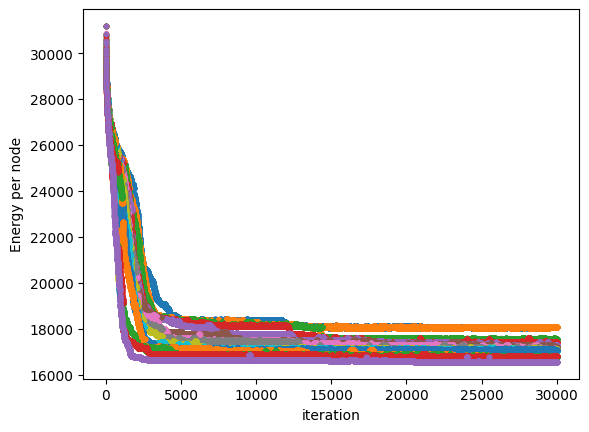

In [18]:
x=np.arange(PasosMC)
for k_nt in range(0,N_t):
    energies_pasos_temper = energies_pasos[k_nt,:] 
    plt.plot(x,energies_pasos_temper,'.',label='%s temper' % tempers[k_nt])
    plt.xlabel('iteration')
    plt.ylabel('Energy per node')
# plt.legend()
plt.show()

In [39]:
# Voy a construir un diccionario para guardar todo
d_store={}
string = "celegant_normal_k4_unk_same_L2_0.pickle"
d_store["Datos_energy"] = energies_pasos
d_store["Permus"] = P_t
d_store["Permus_inv"] = P_inv_t
d_store["Permusstore"] = P_store
d_store["L_latent"] = L_t
d_store["temper"] = tempers
d_store["A"] = A
d_store["start_groups"] = start_groups
d_store["end_groups"] = end_groups
d_store["groups"] = groups_store
d_store["labels_unkwn"] = labels_unkwons_t
d_store["posisstore_unkwn"] = posi_store
d_store["num"] = num
d_store["vector"] = vector_unkwn_store


d_store["P_inter"] = P_intermediate_shot
d_store["E_inter"] = E_intermediate_shot
d_store["E_store"] = Energy_store
d_store["L_store"] = L_store
d_store["posi_store"] = posi_store

d_store["E_groundtruth"] = Energy_new
d_store["Pasos_corr_ini"] = Pasos_corr 
d_store["Step_corr"] = Long_corr 

file1 = open(string,"wb")
pickle.dump( d_store, file1)
# prueba = pickle.load(open(string, "rb"))

In [40]:
# Voy a construir un diccionario para guardar todo
d_store={}
d_store["Datos_energy"] = energies_pasos
d_store["Permus"] = P_t
d_store["Permus_inv"] = P_inv_t
d_store["Permusstore"] = P_store
d_store["L_latent"] = L_t
d_store["temper"] = tempers
d_store["A"] = A
d_store["start_groups"] = start_groups
d_store["end_groups"] = end_groups
d_store["groups"] = groups_store
d_store["labels_unkwn"] = labels_unkwons_t
d_store["posisstore_unkwn"] = posi_store
d_store["num"] = num
d_store["vector"] = vector_unkwn_store


d_store["P_inter"] = P_intermediate_shot
d_store["E_inter"] = E_intermediate_shot
d_store["E_store"] = Energy_store
d_store["L_store"] = L_store
d_store["posi_store"] = posi_store


d_store["E_groundtruth"] = Energy_new
d_store["Pasos_corr_ini"] = Pasos_corr 
d_store["Step_corr"] = Long_corr 

file1 = open(string,"wb")
pickle.dump( d_store, file1)
prueba = pickle.load(open(string, "rb"))

In [21]:
np.sort(labels_unkwons_ini[1,:])

array([  1,  13,  15,  31,  48,  50,  65,  81,  92, 107, 120, 124, 134,
       149, 158, 165, 173, 195, 209, 211, 212])